In [80]:
import os
import asyncio
from supabase import create_client, Client
from dotenv import load_dotenv

load_dotenv()
url = os.environ['SUPABASE_URL']
key = os.environ['SUPABASE_KEY']
supabase = create_client(url, key)
user_id = "20284713-5cd6-4199-8313-0d883f0711a1"

start = 0
end = 10000
states = []
results = ['placeholder']
while len(results) > 0:
    results = supabase.table('states').select('*').gt('metadata->>timestamp', 0).eq('user_id', user_id).range(start, end).execute().data

    states += results
    
    start += 10000
    end += 10000

In [81]:
len(states)

61000

In [82]:
# sort data by timestamp
states = [sample for sample in states if sample['metadata'].get('timestamp') is not None]
states = sorted(states, key=lambda x: x['metadata']['timestamp'])

In [83]:
import datetime
import pandas as pd

window_size = datetime.timedelta(minutes=5)

windows = []
for state in states:
  timestamp = state['created_at']
  
  # Parse timestamp string with strptime
  start_time = datetime.datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%f%z")

  # Convert timedelta to seconds and add to start_time
  end_time = start_time + datetime.timedelta(seconds=window_size.total_seconds()) 
  
  windows.append({
    'start': start_time,
    'end': end_time  
  })

df = pd.DataFrame(windows)
df

,start,end
0,2023-07-26 22:22:53.893872+00:00,2023-07-26 22:27:53.893872+00:00
1,2023-07-26 22:22:54.073011+00:00,2023-07-26 22:27:54.073011+00:00
2,2023-07-26 22:22:55.118600+00:00,2023-07-26 22:27:55.118600+00:00
3,2023-07-26 22:22:55.165455+00:00,2023-07-26 22:27:55.165455+00:00
4,2023-07-26 22:22:55.319136+00:00,2023-07-26 22:27:55.319136+00:00
...,...,...
60995,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00
60996,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00
60997,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00
60998,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00


In [86]:
tags = supabase.table('tags').select('text, created_at').eq('user_id', user_id).order('created_at').execute().data

In [87]:
tags[0]

{'text': 'a bit down', 'created_at': '2023-07-28T17:52:56.590523+00:00'}

In [15]:
from anthropic import AsyncAnthropic
anthropic = AsyncAnthropic()
emotions = []
for tag in tags:
    # for each tags, infer the emotion felt by the person
    completion = await anthropic.completions.create(
        model="claude-2",
        max_tokens_to_sample=10,
        prompt=f"""
Human: Your only job is to classify the emotion of the person in a given tag.
Tags are given by the users throughout his day in a web app and should say about what he is doing, feeling, or thinking.

The person is in the same time recording his/her brain activity with a EEG device.

Classifications will then be used to train a model to predict the emotion of the person based on his brain activity.

What is the emotion of the person in this tag? {tag["text"]}

ONLY SAY ONE EMOTION, NOTHING ELSE. YOUR ANSWER SHOULD BE ONE WORD. DO NOT TALK ABOUT THE CONTEXT OR THE TAG.
Examples: happy, sad, angry, anxious, calm, excited, etc.

If you don't know, say "none".

Assistant:""",
    )
    print(completion.completion)
    emotions.append({ "emotion": completion.completion.strip().lower(), "tag": tag["text"], "created_at": tag["created_at"] })
emotions


 sad
 happy
 happy
 calm
 neutral
 none
 energetic
 tired
 tired
 calm
 calm
 focused
 calm
 calm
 happy
 annoyed
 calm
 focused
 focused
 focused
 calm
 focused
 calm
 calm
 full
 neutral
 happy
 tired
 Calm
 happy
 happy
 calm
 calm
 anxious
 energetic


In [88]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = []
for tag in tags:
    embedding = model.encode(tag['text']).tolist()
    embeddings.append({'text': tag['text'], 'embedding': embedding, 'created_at': tag['created_at']})

2023-08-13 17:40:31,563:INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-08-13 17:40:31,765:INFO - Use pytorch device: cpu
Batches: 100%|██████████| 1/1 [00:00<00:00, 87.06it/s]


In [89]:
import pandas as pd
import datetime

tag_window = datetime.timedelta(minutes=2.5)
extended_window = datetime.timedelta(hours=10)
df['embeddings'] = None
df['embeddings'] = df['embeddings'].astype('object')
for index, window in df.iterrows():
    window_center = window['start'] + (window['end'] - window['start']) / 2
    window_start = window_center - tag_window/2
    window_end = window_center + tag_window/2
    extended_start = window_center - extended_window

    # Find closest tag within the 2.5-minute window
    tags_within_window = [tag for tag in embeddings if extended_start <= pd.Timestamp(tag['created_at']) <= window_end]
    if tags_within_window:
        closest_tag = min(tags_within_window, key=lambda x: abs(window_center - (x['created_at'] if isinstance(x['created_at'], datetime.datetime) else datetime.datetime.strptime(x['created_at'], '%Y-%m-%dT%H:%M:%S.%f%z'))))
        closest_timestamp = pd.Timestamp(closest_tag['created_at']) if isinstance(closest_tag['created_at'], str) else closest_tag['created_at']

        if window_start <= closest_timestamp <= window_end:

            df.at[index, 'embeddings'] = closest_tag['embedding']
            df.at[index, 'tag'] = closest_tag['text']
            df.at[index, 'tag_created_at'] = closest_tag['created_at']
        else:

            # If the closest tag is not within the 2.5-minute window, check the extended 10-hour window for the closest past tag
            past_tags = [tag for tag in tags_within_window if extended_start <= pd.Timestamp(tag['created_at']) <= window_center]
            if past_tags:
                closest_past_tag = min(past_tags, key=lambda x: abs(window_center - (x['created_at'] if isinstance(x['created_at'], datetime.datetime) else datetime.datetime.strptime(x['created_at'], '%Y-%m-%dT%H:%M:%S.%f%z'))))
                df.at[index, 'embeddings'] = closest_past_tag['embedding']
                df.at[index, 'tag'] = closest_past_tag['text']
                df.at[index, 'tag_created_at'] = closest_past_tag['created_at']
            else:
                df.at[index, 'embeddings'] = None
                df.at[index, 'tag'] = None
                df.at[index, 'tag_created_at'] = None
    else:
        df.at[index, 'embeddings'] = None
        df.at[index, 'tag'] = None
        df.at[index, 'tag_created_at'] = None

df


,start,end,embeddings,tag,tag_created_at
0,2023-07-26 22:22:53.893872+00:00,2023-07-26 22:27:53.893872+00:00,None,NaN,NaN
1,2023-07-26 22:22:54.073011+00:00,2023-07-26 22:27:54.073011+00:00,None,NaN,NaN
2,2023-07-26 22:22:55.118600+00:00,2023-07-26 22:27:55.118600+00:00,None,NaN,NaN
3,2023-07-26 22:22:55.165455+00:00,2023-07-26 22:27:55.165455+00:00,None,NaN,NaN
4,2023-07-26 22:22:55.319136+00:00,2023-07-26 22:27:55.319136+00:00,None,NaN,NaN
...,...,...,...,...,...
60995,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00,"[0.016733378171920776, -0.031602680683135986, ...",just drank my 2nd coffee of the day - feel mor...,2023-08-13T08:54:33.002561+00:00
60996,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00,"[0.016733378171920776, -0.031602680683135986, ...",just drank my 2nd coffee of the day - feel mor...,2023-08-13T08:54:33.002561+00:00
60997,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00,"[0.016733378171920776, -0.031602680683135986, ...",just drank my 2nd coffee of the day - feel mor...,2023-08-13T08:54:33.002561+00:00
60998,2023-08-13 15:21:37.930140+00:00,2023-08-13 15:26:37.930140+00:00,"[0.016733378171920776, -0.031602680683135986, ...",just drank my 2nd coffee of the day - feel mor...,2023-08-13T08:54:33.002561+00:00


In [90]:
from bisect import bisect_left, bisect_right
# Convert start and end columns to Timestamps just once
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

# Sort states by 'created_at' if it's not sorted yet
states = sorted(states, key=lambda x: x['created_at'])
state_timestamps = [pd.Timestamp(state['created_at']) for state in states]

def compute_alpha_avg(window_start, window_end):
    # Use binary search or other quick methods to find relevant states for this window
    start_idx = bisect_left(state_timestamps, window_start)
    end_idx = bisect_right(state_timestamps, window_end)

    relevant_states = states[start_idx:end_idx]
    alpha_values = [state['metadata']['data']['alpha'] for state in relevant_states]
    flattened_alpha = [value for sublist in alpha_values for value in sublist]
    
    return sum(flattened_alpha) / len(flattened_alpha) if flattened_alpha else None

# Use Pandas apply for speed
df['alpha_avg'] = df.apply(lambda row: compute_alpha_avg(row['start'], row['end']), axis=1)


In [94]:
df.alpha_avg.describe()

count    61000.000000
mean       132.185623
std        650.494207
min          0.495413
25%          2.915869
50%          4.972835
75%         13.126839
max       6378.715381
Name: alpha_avg, dtype: float64

<Axes: >

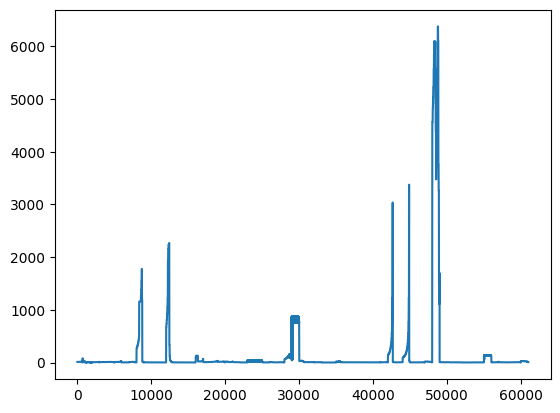

In [95]:
df.alpha_avg.plot()

In [98]:
df.shape

(61000, 6)

In [102]:
embeddings_list

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [128]:
import numpy as np

# First, find out the typical length of an embedding. Assuming that most embeddings have the same length.
typical_length = len(df.loc[df['embeddings'].notna(), 'embeddings'].iloc[0])

# Replace None with zero vectors of typical_length
df['embeddings'] = df['embeddings'].apply(lambda x: x if x is not None else [0]*typical_length)

# Convert the embeddings column to a list
embeddings_list = df['embeddings'].tolist()

# Now proceed with KMeans clustering
from sklearn.cluster import KMeans

K = 10  # Example value
kmeans = KMeans(n_clusters=K, random_state=0)
df['cluster_labels'] = kmeans.fit_predict(embeddings_list)

# If you wish to reassign the cluster labels for rows with zero vectors, you can do so.
# For instance, setting them to a specific cluster label or a placeholder value:
placeholder_value = -1
df.loc[df['embeddings'].apply(lambda x: x == [0]*typical_length), 'cluster_labels'] = placeholder_value


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [129]:
from sklearn.model_selection import train_test_split

X = df[['alpha_avg']]
y = df['cluster_labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# Evaluate the classifier
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 97.69%


In [107]:
new_data = df

In [113]:
from sklearn.metrics.pairwise import cosine_similarity

# Assume new_data is a DataFrame with columns similar to your original df
# And you have a column named 'alpha_avg' that contains the brain waves

# 1. Preprocess the new data (if needed)
# Assuming you have some preprocessing function named 'preprocess'
# new_data['alpha_avg'] = preprocess(new_data['alpha_avg'])

# 2. Predict the cluster label
new_data['predicted_cluster'] = clf.predict(new_data['alpha_avg'].values.reshape(-1, 1))

# 3. & 4. Find the most similar embeddings and their corresponding tags
def get_similar_tags(row):
    alpha_value = row['alpha_avg']
    
    # Ensure the data is always in the correct shape
    predicted_cluster = clf.predict(np.array(alpha_value).reshape(-1, 1))[0]
    
    cluster_data = df[df['cluster_labels'] == predicted_cluster]
    
    # Compute cosine similarity between the current embeddings and embeddings in the cluster
    cosine_similarities = cosine_similarity([row['embeddings']], cluster_data['embeddings'].tolist())
    
    # Get the indices of the top 5 most similar embeddings
    top_indices = cosine_similarities[0].argsort()[-5:][::-1]
    
    # Return the corresponding tags for these embeddings
    return cluster_data['tag'].iloc[top_indices].tolist()

# Use only the first 5 rows of the new_data DataFrame
subset_data = new_data.iloc[:5]

# Predict the cluster label for the subset
subset_data['predicted_cluster'] = clf.predict(subset_data['alpha_avg'].values.reshape(-1, 1))

# Get the most similar tags for the subset
subset_data['most_similar_tag'] = subset_data.apply(get_similar_tags, axis=1)

# Display the results
print(subset_data['most_similar_tag'].values)


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/hq/swhzs3js29z7mb5b7ycnjcnm0000gn/T/ipykernel_40342/1420145066.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['predicted_cluster'] = clf.predict(subset_data['alpha_avg'].values.reshape(-1, 1))
/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/sklearn/base.py:464: Us

[list([None, nan, nan, nan, nan]) list([None, nan, nan, nan, nan])
 list([None, nan, nan, nan, nan]) list([None, nan, nan, nan, nan])
 list(['back from sf to berlin - long flight, routines broken', 'neurotech event', 'neurotech event', 'neurotech event', 'neurotech event'])]


In [119]:
subset_data['most_similar_tag'].to_dict()[4]

['back from sf to berlin - long flight, routines broken',
 'neurotech event',
 'neurotech event',
 'neurotech event',
 'neurotech event']

In [124]:
from anthropic import AsyncAnthropic
anthropic = AsyncAnthropic()
# for each tags, infer the emotion felt by the person
completion = await anthropic.completions.create(
    model="claude-2",
    max_tokens_to_sample=300,
    prompt=f"""Human: We found these journal logs associated to the user brain activity:{subset_data['most_similar_tag'].to_dict()[4]}
Say something that make sense to ask the user about the logs.
Basically means the user is now thinking about these journal logs.
Ask about his emotions, feelings, thoughts, etc.
"I noticed you have been feeling about xxx, how are you feeling about it?"
Assistant:""",
)
print(completion.completion)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 Based on the journal logs you provided, it seems the user recently returned from a trip to San Francisco and attended several neurotechnology events. Here are some thoughtful questions I could ask them:

"I noticed your journal mentioned returning from a trip to San Francisco and attending several neurotech events. How was your trip? What were the neurotech events about and how did you find them?"

"It sounds like you've had a busy time traveling and going to neurotech events. How are you feeling after all of that - are you feeling energized by new ideas or in need of some rest?" 

"I see you went to a few back-to-back neurotech events after getting back from travel.

In [5]:
import pickle


len(states)
# save to file
open('states.pkl', 'wb').write(pickle.dumps(states))

352539478

In [6]:
# read
states = pickle.load(open('states.pkl', 'rb'))
len(states)

749737

In [26]:
states[0]

{'id': 223981,
 'created_at': '2023-08-03T21:26:31.331463+00:00',
 'probability': None,
 'metadata': {'data': {'beta': [1.68435984063952,
    2.2897360051429865,
    3.2084302479863656,
    1.3297480191685276,
    1.2772257538576879,
    1.6343725680497778,
    2.8271138037048766,
    1.5299680673750928],
   'alpha': [3.80878831622355,
    3.2020622091061486,
    20.626949433084434,
    2.6742892150936934,
    1.706945546195626,
    3.8134742410365194,
    4.552923171141931,
    2.5127518361239396],
   'delta': [11.202560308605088,
    10.462746349973376,
    38.444284522750316,
    7.101878385099328,
    8.603298830627537,
    9.171056975350652,
    7.388270105118908,
    8.542119265916043],
   'gamma': [0.6987282683419215,
    0.6872111373375639,
    1.179046747294864,
    0.6030847958181215,
    0.7493798841195819,
    0.542427870149803,
    0.6912074803627185,
    0.9369746308799457],
   'theta': [9.53528726020572,
    8.024826933092655,
    30.03713568239406,
    5.869324432029654

In [67]:
states[0]

{'id': 223981,
 'created_at': '2023-08-03T21:26:31.331463+00:00',
 'probability': None,
 'metadata': {'data': {'beta': [1.68435984063952,
    2.2897360051429865,
    3.2084302479863656,
    1.3297480191685276,
    1.2772257538576879,
    1.6343725680497778,
    2.8271138037048766,
    1.5299680673750928],
   'alpha': [3.80878831622355,
    3.2020622091061486,
    20.626949433084434,
    2.6742892150936934,
    1.706945546195626,
    3.8134742410365194,
    4.552923171141931,
    2.5127518361239396],
   'delta': [11.202560308605088,
    10.462746349973376,
    38.444284522750316,
    7.101878385099328,
    8.603298830627537,
    9.171056975350652,
    7.388270105118908,
    8.542119265916043],
   'gamma': [0.6987282683419215,
    0.6872111373375639,
    1.179046747294864,
    0.6030847958181215,
    0.7493798841195819,
    0.542427870149803,
    0.6912074803627185,
    0.9369746308799457],
   'theta': [9.53528726020572,
    8.024826933092655,
    30.03713568239406,
    5.869324432029654

In [70]:

import numpy as np

# sort data by timestamp
states = [sample for sample in states if sample['metadata'].get('timestamp') is not None]
states = sorted(states, key=lambda x: x['metadata']['timestamp'])

data = [sample['metadata']['data'] for sample in states if sample['metadata'].get('data') is not None]
timestamps = [sample['metadata']['timestamp'] for sample in states if sample['metadata'].get('data') is not None]
flattened_data = []
for sample in data:
    flattened = []
    for band in ['gamma']: #['alpha', 'beta', 'delta', 'gamma', 'theta']:
        flattened.extend(sample[band])
    flattened_data.append(flattened)

In [6]:
# save to file "data.json" like so {"flattened_data": [...], "timestamps": [...]}
import json

# Save to JSON file
with open('data.json', 'w') as f:
    json.dump({
        'flattened_data': np.array(flattened_data).tolist(), 
        'timestamps': np.array(timestamps).tolist()
    }, f)

In [71]:
len(flattened_data)

584368

In [77]:
timestamps = np.array(timestamps)
X = np.array(flattened_data)
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

seq_length = 4 # number of time steps in each sequence

# Determine the total number of sequences that can be extracted
num_sequences = X.shape[0] // seq_length

# Truncate the data to only include complete sequences
X = X[:num_sequences * seq_length]

# Now reshape should work
X = X.reshape(-1, seq_length, X.shape[1])

# Do the same for timestamps
timestamps = timestamps[:num_sequences * seq_length]
timestamps = timestamps.reshape(-1, seq_length, 1)

X = np.concatenate([X, timestamps], axis=-1)

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42, shuffle=False)


In [31]:
X_train.shape

(116873, 4, 9)

In [78]:
import torch
import torch.nn as nn

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)

seq_len = 4
num_features = 9 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder 
        self.lstm1 = nn.LSTM(num_features, 64, batch_first=True, bidirectional=True, dropout=0.2)
        self.lstm2 = nn.LSTM(128, 32, batch_first=True, bidirectional=True, dropout=0.2)  # bidirectional doubles the output size
        
        # Decoder
        self.lstm3 = nn.LSTM(64, 128, batch_first=True, dropout=0.2)
        self.lstm4 = nn.LSTM(128, num_features, batch_first=True)  # Not bidirectional to match input size

    def forward(self, x):
        # Encoder
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Decoder
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        
        return x

model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_loader = torch.utils.data.DataLoader(dataset=X_train, batch_size=64, shuffle=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

for epoch in range(1000):
    for batch_X in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    
    loss.backward()
    optimizer.step()
    # scheduler.step()

# Evaluate on validation set 
with torch.no_grad():
    outputs = model(X_val)
    val_loss = criterion(outputs, X_val)

print(f'Validation Loss: {val_loss.item():.4f}')

Epoch 1, Loss: 317730755150839440998400.0000
Epoch 2, Loss: 317773917649668159832064.0000
Epoch 3, Loss: 317760226706800953524224.0000
Epoch 4, Loss: 317752012141080629739520.0000
Epoch 5, Loss: 317793337171261381410816.0000
Epoch 6, Loss: 317820070538649452675072.0000
Epoch 7, Loss: 317771467691470870282240.0000
Epoch 8, Loss: 317744446093706647306240.0000
Epoch 9, Loss: 317705498964129147256832.0000
Epoch 10, Loss: 317763469298532660281344.0000
Epoch 11, Loss: 317753993724916672757760.0000
Epoch 12, Loss: 317772656641772496093184.0000
Epoch 13, Loss: 317786383613436721364992.0000
Epoch 14, Loss: 317749994528447567757312.0000
Epoch 15, Loss: 317799353980363548393472.0000
Epoch 16, Loss: 317764045759284963704832.0000
Epoch 17, Loss: 317747004138294993747968.0000
Epoch 18, Loss: 317860674992889825067008.0000
Epoch 19, Loss: 317811279512176825466880.0000
Epoch 20, Loss: 317789662233965447086080.0000
Epoch 21, Loss: 317806343566985227403264.0000
Epoch 22, Loss: 317809225870746744520704.00

In [27]:
import torch
import torch.nn as nn 
import numpy as np
from sklearn.cluster import KMeans
from torch.utils.data import Dataset, DataLoader

X_train, X_val = train_test_split(X, test_size=0.2, random_state=42, shuffle=False)

# Dataset
class EEGDataset(Dataset):

    def __init__(self, data):
        self.data = torch.from_numpy(data).float()

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

X_train = X_train.mean(axis=1, keepdims=True)
train_dataset = EEGDataset(X_train)
val_dataset = EEGDataset(X_val)

# Model 
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=(3,3), padding=1),
            nn.ReLU()
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=(3,3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

  running_loss = 0.0
  for i, data in enumerate(train_loader):
    inputs = data
    recon = model(inputs)  
    loss = criterion(recon, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)

  # Validate
  val_loss = 0.0
  for i, data in enumerate(val_loader):
    print(data.shape)
    inputs = data
    recon = model(inputs)
    loss = criterion(recon, inputs)

    val_loss += loss.item()

  val_loss = val_loss / len(val_loader)
  val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Extract encoder features
encoded = model.encoder(torch.from_numpy(X_train).float())

# Cluster with K-Means
kmeans = KMeans(n_clusters=5).fit(encoded.detach().numpy())
y_kmeans = kmeans.predict(encoded.detach().numpy())

print('Completed autoencoder training and clustering!')

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 32, 1, 9] to have 1 channels, but got 32 channels instead

In [2]:
import torch
import torch.nn as nn
import math 

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        
        # Use a linear layer instead of an embedding layer
        self.encoder = nn.Linear(ntoken, ninp)
        
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        # Apply the linear layer to the input data
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [9]:
from torch.utils.data import Dataset, DataLoader

class BrainwaveDataset(Dataset):
    def __init__(self, data, mask_percentage=0.15):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor
        self.mask_percentage = mask_percentage

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        mask = torch.rand(sample.shape) < self.mask_percentage
        masked_sample = sample.clone().detach()
        masked_sample[mask] = 0
        return masked_sample, sample, mask

# Instantiate the model
n_channels = 1 # 5
ntokens = (n_channels * 8) + 1
emsize = 1024 # embedding dimension
nhid = 80 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 5 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
device = 'cpu'
num_epochs = 200
train_dataset = BrainwaveDataset(X_train)
val_dataset = BrainwaveDataset(X_val)
import torch.optim as optim


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize model
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

# Loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_dataloader):
        masked_sample, sample, mask = batch
        masked_sample = masked_sample.to(device)
        sample = sample.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()

        output = model(masked_sample)
        
        loss = criterion(output[mask], sample[mask])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    print(f"Epoch {epoch}, Loss {epoch_loss / len(train_dataloader)}")



Epoch 0, Loss 187154403210.7086
Epoch 1, Loss 188778681564.20886
Epoch 2, Loss 188889827391.24536
Epoch 3, Loss 187465177185.74283
Epoch 4, Loss 186889672636.15497
Epoch 5, Loss 188641610117.82144
Epoch 6, Loss 188023230020.1325
Epoch 7, Loss 187812192651.571
Epoch 8, Loss 188052756416.75464
Epoch 9, Loss 187523751443.83606
Epoch 10, Loss 188140353541.74957
Epoch 11, Loss 188430618626.29984
Epoch 12, Loss 188015199357.91577
Epoch 13, Loss 188057951018.6906
Epoch 14, Loss 188217331162.3403
Epoch 15, Loss 186679129032.2291
Epoch 16, Loss 188718918923.3554
Epoch 17, Loss 188504337155.59348
Epoch 18, Loss 187990264322.01236
Epoch 19, Loss 188724308946.57834
Epoch 20, Loss 188604058555.58002
Epoch 21, Loss 187956703064.1123
Epoch 22, Loss 187837421743.9371
Epoch 23, Loss 187395677830.82764
Epoch 24, Loss 188099150904.92084
Epoch 25, Loss 188225576858.8074
Epoch 26, Loss 187968485174.76474


KeyboardInterrupt: 

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dropout, BatchNormalization, Bidirectional, LeakyReLU, Dense
from tensorflow.keras.regularizers import l1
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

wandb.init(project="neurosity-unlabelled")

n_features = X_train.shape[2]  # Number of features
timesteps = X_train.shape[1]  # Number of time steps

# Define the encoder
inputs = Input(shape=(timesteps, n_features))
x = LSTM(256, return_sequences=True, activity_regularizer=l1(0.001))(inputs)
x = LSTM(128, return_sequences=True, activity_regularizer=l1(0.001))(x)
x = LSTM(64, return_sequences=False, activity_regularizer=l1(0.001))(x)
x = Dropout(0.2)(x)
encoded = BatchNormalization()(x)

# Introduce a Dense layer with LeakyReLU activation
x = Dense(64)(encoded)
x = LeakyReLU()(x)

# Define the repeater and decoder
repeated = RepeatVector(timesteps)(x)
x = LSTM(64, return_sequences=True)(repeated)
x = LSTM(128, return_sequences=True)(x)
decoded = LSTM(n_features, return_sequences=True)(x)

# Define the full autoencoder
autoencoder = Model(inputs, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# Fit the model
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), 
                callbacks=[early_stop, WandbCallback(), reduce_lr])


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▅▃█▃▆▁▆█▃▃▅
val_loss,▁▁▁▁▁▁▁▁▁▁▁
best_epoch,0
best_val_loss,6.971114657447387e+22
epoch,10
loss,6.970027038137377e+22
val_loss,6.971114657447387e+22


Epoch 1/100
288/289 [============================>.] - ETA: 0s - loss: 69700247863375633055744.0000

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-07-30 15:21:54,068:INFO - Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_152132-djgh7qxv/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_152132-djgh7qxv/files/model-best)... Done. 0.0s


289/289 [==============================] - 14s 37ms/step - loss: 69700247863375633055744.0000 - val_loss: 69711146574473869656064.0000 - lr: 0.0010
Epoch 2/100
289/289 [==============================] - 5s 18ms/step - loss: 69700261374174515167232.0000 - val_loss: 69711146574473869656064.0000 - lr: 0.0010
Epoch 3/100
289/289 [==============================] - 5s 17ms/step - loss: 69700279388573024649216.0000 - val_loss: 69711146574473869656064.0000 - lr: 0.0010
Epoch 4/100
289/289 [==============================] - 5s 16ms/step - loss: 69700247863375633055744.0000 - val_loss: 69711146574473869656064.0000 - lr: 5.0000e-04
Epoch 5/100
289/289 [==============================] - 5s 17ms/step - loss: 69700288395772279390208.0000 - val_loss: 69711146574473869656064.0000 - lr: 5.0000e-04
Epoch 6/100
289/289 [==============================] - 5s 16ms/step - loss: 69700279388573024649216.0000 - val_loss: 69711146574473869656064.0000 - lr: 2.5000e-04
Epoch 7/100
289/289 [========================

In [25]:
# Use the autoencoder to reconstruct the validation data
X_val_reconstructed = autoencoder.predict(X_val)

# Calculate the mean squared error for each sequence
mse = np.mean(np.power(X_val - X_val_reconstructed, 2), axis=(1,2))

# Print the mean and standard deviation of the MSE
print(f'MSE mean: {np.mean(mse)}, standard deviation: {np.std(mse)}')

73/73 [==============================] - 1s 4ms/step
MSE mean: 6.971112834346377e+22, standard deviation: 2.966316144505314e+18


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dropout, BatchNormalization, Bidirectional, GRU, LayerNormalization, Dense
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

wandb.init(project="neurosity-unlabelled")

n_features = X_train.shape[2]  # Number of features
timesteps = X_train.shape[1]  # Number of time steps

from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.models import Sequential
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Define parameters
d_model = 128
num_heads = 4

# Define the encoder
inputs = Input(shape=(timesteps, n_features))
x = Dense(d_model)(inputs)  # Transform the input
x = PositionalEncoding(timesteps, d_model)(x)  # Pass the transformed input
x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x, x)  # Corrected this line
encoder_outputs = LayerNormalization(epsilon=1e-6)(x)

# Define the decoder
x = Dense(d_model)(inputs)  # Transform the input
x = PositionalEncoding(timesteps, d_model)(x)  # Pass the transformed input
x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x, encoder_outputs) # Use encoder_outputs as value
x = Dropout(0.1)(x)
x = LayerNormalization(epsilon=1e-6)(x + encoder_outputs)
decoded = Dense(n_features)(x)

# Define the Transformer model
transformer = Model(inputs, decoded)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Compile the model
transformer.compile(optimizer='adam', loss='mse')

# Reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# Fit the model
transformer.fit(X_train, X_train, epochs=200, batch_size=64, validation_data=(X_val, X_val), 
                callbacks=[early_stop, WandbCallback()])

In [1]:
import numpy as np
import json
import os

# Directory where the files are stored
directories = [
    '../hello-world/2023-07-30-08-39-11/',
    '../hello-world/2023-07-30-12-01-14/',
]

files = []

for directory in directories:
    for filename in os.listdir(directory):
        files.append(os.path.join(directory, filename))

# Create an empty list to store data, labels and timestamps
data_list, labels, timestamps = [], [], []

# Initialize a counter for the number of samples
num_samples = 0

# Iterate over all files in the directory
for filename in files:
    # Check if the file is a JSONL file
    if filename.endswith('.jsonl'):
        # Derive label from the filename (excluding the timestamp and extension)
        label = filename.split('/')[-1].split('-')[0]

        # Open and read the JSON lines file
        with open(os.path.join(filename), 'r') as f:
            for line in f:
                # Parse each JSON line into a dictionary
                data = json.loads(line)

                # Extract data arrays and flatten
                flattened_data = []
                for band in ['alpha', 'beta', 'delta', 'gamma', 'theta']:
                    flattened_data.extend(data['data'][band])  # Extend instead of append

                data_list.append(flattened_data)
                labels.append(label)
                timestamps.append(data['timestamp'])

                # Increment the counter for the number of samples
                num_samples += 1

# Convert the lists to numpy arrays
X = np.array(data_list)
y = np.array(labels)

timestamps = np.array(timestamps)

# Check the length of a flattened_data
data_len = len(data_list[0])

# Adjust the num_samples to the largest number less than or equal to num_samples divisible by 4
num_samples = num_samples // 4 * 4  # this will ensure that num_samples is divisible by 4

# Then, truncate the lists to ensure they only include complete sets of 4-timestamp samples
X = X[:num_samples]
y = y[:num_samples]
timestamps = timestamps[:num_samples]

# Now you can proceed with reshaping
X = X.reshape(num_samples // 4, 4, data_len)  # 4 timestamps with data_len features each
timestamps = timestamps.reshape(num_samples // 4, 4, 1)  # (n_samples, 4, 1)

# Reshape X to have 3 dimensions: number of samples, sequence length, number of features
X = X.reshape(num_samples // 4, 4, data_len)  # 4 timestamps with data_len features each

# Reshape timestamps to have the same number of rows as X and add an extra dimension
timestamps = timestamps.reshape(num_samples // 4, 4, 1)  # (n_samples, 4, 1)

# Add the timestamp as an additional channel to the reshaped array
X = np.concatenate((X, timestamps), axis=2)  # (n_samples, 4, data_len + 1)

mean = np.mean(X[:, :, :-1], axis=(0, 1), keepdims=True)
std = np.std(X[:, :, :-1], axis=(0, 1), keepdims=True)
X[:, :, :-1] = (X[:, :, :-1] - mean) / std

# Assuming that you want to use 80% of data for training and remaining 20% for testing
num_train = int(0.8 * len(X))

# Split the data into training and testing sets
X_train, X_test = X[:num_train], X[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

# Shuffle the training data
# idx = np.random.permutation(len(X_train))
# X_train, y_train = X_train[idx], y_train[idx]

# compute unique classes in y
n_classes = len(np.unique(y))

from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit the encoder to the training labels
le.fit(y)

# Transform the training and testing labels
y_train = le.transform(y_train)
y_test = le.transform(y_test)

print(X_train.shape, y_train.shape)


(10188, 4, 41) (10188,)


In [4]:
X_train.shape

(10188, 4, 41)

In [9]:
import pandas as pd
import plotly.graph_objects as go

# Convert labels and data into DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps.flatten(),
    'Label': y.flatten(),  # convert back to original labels
    'Average Feature Value': np.mean(X[:, :, :-1], axis=-1).flatten()  # calculate mean across the last dimension (excluding timestamp)
})

# Group by label and calculate mean at each timestamp
df_grouped = df.groupby(['Timestamp', 'Label']).mean().reset_index()

# Initialize a plotly figure
fig = go.Figure()

# Add a line for each label
for label in df_grouped['Label'].unique():
    df_label = df_grouped[df_grouped['Label'] == label]
    fig.add_trace(go.Scatter(
        x=df_label['Timestamp'],  # use the timestamps for the x-axis
        y=df_label['Average Feature Value'],  # use the averaged feature values for the y-axis
        mode='lines',
        name=label
    ))

fig.update_layout(
    title='Timeseries plot with a line per label',
    xaxis_title='Timestamp',
    yaxis_title='Average Feature Value',
)

fig.show()


In [ ]:
predicted_labels = model.predict(X_test)  # This is just an example
predicted_labels_str = le.inverse_transform(predicted_labels)

## to huggingface

In [28]:
from datasets import Dataset, DatasetDict

# Convert numpy arrays to lists for Dataset compatibility
X_train_list = X_train.tolist()
y_train_list = y_train.tolist()
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

# Create a Dataset for each of the train and test splits
train_dataset = Dataset.from_dict({
    'data': X_train_list,
    'label': y_train_list
})

test_dataset = Dataset.from_dict({
    'data': X_test_list,
    'label': y_test_list
})

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# Login to Hugging Face (This will ask for your Hugging Face credentials)
!huggingface-cli login

# Push the dataset to the Hub
dataset_dict.save_to_disk("hf_ds")

!huggingface-cli repo create neurosity_word_classification  # create a repository on HuggingFace

# replace 'username' with your Hugging Face username, and 'your_dataset_name' with the name you want to give to your dataset.
!cd hf_ds && git init && git add . && git commit -m "Initial commit" && git remote add origin https://huggingface.co/louis030195/neurosity_word_classification && git push origin master

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ArrowInvalid: Column 1 named label expected length 2547 but got length 40752

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import wandb
from wandb.keras import WandbCallback

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

input_shape = X_train.shape[1:]

wandb.init(project="neurosity")

model = build_model(
    input_shape,
    head_size=8,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[4],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=False), WandbCallback()]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=8,
    callbacks=callbacks,
)

wandb.finish()

accuracy,▁▅▅▅▄▅▅▆▆▆▆▇█▇██████████
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.2592
best_epoch,13
best_val_loss,4.09411
epoch,23
loss,1.65349
val_accuracy,0.0


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 4, 41)]              0         []                            
                                                                                                  
 layer_normalization_16 (La  (None, 4, 41)                82        ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_8 (Mu  (None, 4, 41)                5385      ['layer_normalization_16[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_16

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_134930-h5s9dp3n/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_134930-h5s9dp3n/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_134930-h5s9dp3n/files/model-best)... Done. 0.0s


636/636 [==============================] - 5s 6ms/step - loss: 1843862656.0000 - accuracy: 0.2068 - val_loss: 3.3328 - val_accuracy: 0.0000e+00
Epoch 2/200
636/636 [==============================] - 2s 3ms/step - loss: 2.5140 - accuracy: 0.2592 - val_loss: 3.4594 - val_accuracy: 0.0000e+00
Epoch 3/200
636/636 [==============================] - 2s 3ms/step - loss: 2.1503 - accuracy: 0.2592 - val_loss: 3.6621 - val_accuracy: 0.0000e+00
Epoch 4/200
636/636 [==============================] - 2s 3ms/step - loss: 1.9557 - accuracy: 0.2592 - val_loss: 3.8604 - val_accuracy: 0.0000e+00
Epoch 5/200
636/636 [==============================] - 2s 3ms/step - loss: 1.8489 - accuracy: 0.2592 - val_loss: 4.0274 - val_accuracy: 0.0000e+00
Epoch 6/200
636/636 [==============================] - 2s 3ms/step - loss: 1.7869 - accuracy: 0.2592 - val_loss: 4.1543 - val_accuracy: 0.0000e+00
Epoch 7/200
636/636 [==============================] - 2s 3ms/step - loss: 1.7482 - accuracy: 0.2592 - val_loss: 4.2572 -

accuracy,▁██████████
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▆▆▇▇██
accuracy,0.2592
best_epoch,0
best_val_loss,3.3328
epoch,10
loss,1.68242
val_accuracy,0.0


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalAveragePooling1D

def build_cnn_model(input_shape, n_classes, filters, kernel_size, dropout=0):
    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(n_classes, activation='softmax'))

    return model

filters = 64
kernel_size = 3

model = build_cnn_model(input_shape, n_classes, filters, kernel_size, dropout=0.2)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

# fit the model
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 2, 64)             7936      
                                                                 
 dropout_27 (Dropout)        (None, 2, 64)             0         
                                                                 
 global_average_pooling1d_4  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_19 (Dense)            (None, 35)                2275      
                                                                 
Total params: 10211 (39.89 KB)
Trainable params: 10211 (39.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/200
128/128 [==============================] - 0s 1ms/step - loss: 62135668736.0000 - accuracy: 0.0667 - val_loss: 2065840896.0000 - val_accuracy: 0.0918
Epoch 2/200
 80/128 [=================>............] - ETA: 0s - loss: 392472736.0000 - accuracy: 0.0654 INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 246559552.0000 - accuracy: 0.0810 - val_loss: 3.4233 - val_accuracy: 0.1011
Epoch 3/200
 69/128 [===============>..............] - ETA: 0s - loss: 3.3970 - accuracy: 0.0985INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 3.3751 - accuracy: 0.0987 - val_loss: 3.3285 - val_accuracy: 0.1011
Epoch 4/200
 69/128 [===============>..............] - ETA: 0s - loss: 3.3098 - accuracy: 0.0906INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 3.2887 - accuracy: 0.0987 - val_loss: 3.2504 - val_accuracy: 0.1011
Epoch 5/200
 71/128 [===============>..............] - ETA: 0s - loss: 3.2293 - accuracy: 0.0955INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 3.2164 - accuracy: 0.0987 - val_loss: 3.1843 - val_accuracy: 0.1011
Epoch 6/200
 76/128 [================>.............] - ETA: 0s - loss: 3.1655 - accuracy: 0.1030INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 3.1554 - accuracy: 0.0987 - val_loss: 3.1287 - val_accuracy: 0.1011
Epoch 7/200
 71/128 [===============>..............] - ETA: 0s - loss: 3.1156 - accuracy: 0.0973INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 3.1038 - accuracy: 0.0987 - val_loss: 3.0818 - val_accuracy: 0.1011
Epoch 8/200
 76/128 [================>.............] - ETA: 0s - loss: 3.0703 - accuracy: 0.0956INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 3.0602 - accuracy: 0.0987 - val_loss: 3.0423 - val_accuracy: 0.1011
Epoch 9/200
 73/128 [================>.............] - ETA: 0s - loss: 3.0289 - accuracy: 0.1012

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 3.0233 - accuracy: 0.0987 - val_loss: 3.0088 - val_accuracy: 0.1011
Epoch 10/200
 75/128 [================>.............] - ETA: 0s - loss: 3.0002 - accuracy: 0.0985INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.9921 - accuracy: 0.0987 - val_loss: 2.9804 - val_accuracy: 0.1011
Epoch 11/200
 93/128 [====================>.........] - ETA: 0s - loss: 2.9689 - accuracy: 0.1006INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.9657 - accuracy: 0.0987 - val_loss: 2.9565 - val_accuracy: 0.1011
Epoch 12/200
 63/128 [=============>................] - ETA: 0s - loss: 2.9474 - accuracy: 0.1024INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.9434 - accuracy: 0.0987 - val_loss: 2.9361 - val_accuracy: 0.1011
Epoch 13/200
 72/128 [===============>..............] - ETA: 0s - loss: 2.9286 - accuracy: 0.0948INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.9243 - accuracy: 0.0987 - val_loss: 2.9189 - val_accuracy: 0.1011
Epoch 14/200
 74/128 [================>.............] - ETA: 0s - loss: 2.9078 - accuracy: 0.1041INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.9079 - accuracy: 0.0987 - val_loss: 2.9040 - val_accuracy: 0.1011
Epoch 15/200
 71/128 [===============>..............] - ETA: 0s - loss: 2.9024 - accuracy: 0.0999INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 2s 18ms/step - loss: 2.8939 - accuracy: 0.0987 - val_loss: 2.8912 - val_accuracy: 0.1011
Epoch 16/200
 69/128 [===============>..............] - ETA: 0s - loss: 2.8786 - accuracy: 0.0978INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.8818 - accuracy: 0.0987 - val_loss: 2.8801 - val_accuracy: 0.1011
Epoch 17/200
 69/128 [===============>..............] - ETA: 0s - loss: 2.8749 - accuracy: 0.1026INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.8713 - accuracy: 0.0987 - val_loss: 2.8705 - val_accuracy: 0.1011
Epoch 18/200
 65/128 [==============>...............] - ETA: 0s - loss: 2.8648 - accuracy: 0.0969INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.8621 - accuracy: 0.0987 - val_loss: 2.8621 - val_accuracy: 0.1011
Epoch 19/200
 71/128 [===============>..............] - ETA: 0s - loss: 2.8574 - accuracy: 0.0988INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8541 - accuracy: 0.0987 - val_loss: 2.8546 - val_accuracy: 0.1011
Epoch 20/200
 63/128 [=============>................] - ETA: 0s - loss: 2.8386 - accuracy: 0.1054INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8469 - accuracy: 0.0987 - val_loss: 2.8481 - val_accuracy: 0.1011
Epoch 21/200
 63/128 [=============>................] - ETA: 0s - loss: 2.8423 - accuracy: 0.0962INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8406 - accuracy: 0.0995 - val_loss: 2.8422 - val_accuracy: 0.0947
Epoch 22/200
 68/128 [==============>...............] - ETA: 0s - loss: 2.8362 - accuracy: 0.1025INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.8349 - accuracy: 0.1015 - val_loss: 2.8370 - val_accuracy: 0.0947
Epoch 23/200
 76/128 [================>.............] - ETA: 0s - loss: 2.8383 - accuracy: 0.1016INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8298 - accuracy: 0.1015 - val_loss: 2.8322 - val_accuracy: 0.0947
Epoch 24/200
 68/128 [==============>...............] - ETA: 0s - loss: 2.8212 - accuracy: 0.1013INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.8252 - accuracy: 0.1015 - val_loss: 2.8279 - val_accuracy: 0.0947
Epoch 25/200
128/128 [==============================] - ETA: 0s - loss: 2.8210 - accuracy: 0.1015INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 4ms/step - loss: 2.8210 - accuracy: 0.1015 - val_loss: 2.8239 - val_accuracy: 0.0947
Epoch 26/200
116/128 [==========================>...] - ETA: 0s - loss: 2.8173 - accuracy: 0.1030INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.8172 - accuracy: 0.1015 - val_loss: 2.8204 - val_accuracy: 0.0947
Epoch 27/200
 66/128 [==============>...............] - ETA: 0s - loss: 2.8052 - accuracy: 0.0980INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.8138 - accuracy: 0.1015 - val_loss: 2.8171 - val_accuracy: 0.0947
Epoch 28/200
123/128 [===========================>..] - ETA: 0s - loss: 2.8107 - accuracy: 0.1010INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8105 - accuracy: 0.1015 - val_loss: 2.8141 - val_accuracy: 0.0947
Epoch 29/200
 63/128 [=============>................] - ETA: 0s - loss: 2.8088 - accuracy: 0.1019INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8076 - accuracy: 0.1015 - val_loss: 2.8113 - val_accuracy: 0.0947
Epoch 30/200
117/128 [==========================>...] - ETA: 0s - loss: 2.8039 - accuracy: 0.1007INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8049 - accuracy: 0.1015 - val_loss: 2.8088 - val_accuracy: 0.0947
Epoch 31/200
 72/128 [===============>..............] - ETA: 0s - loss: 2.7980 - accuracy: 0.1083INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 2s 17ms/step - loss: 2.8025 - accuracy: 0.1015 - val_loss: 2.8063 - val_accuracy: 0.0947
Epoch 32/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7948 - accuracy: 0.1016INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.8001 - accuracy: 0.1015 - val_loss: 2.8041 - val_accuracy: 0.0947
Epoch 33/200
 75/128 [================>.............] - ETA: 0s - loss: 2.8066 - accuracy: 0.0998INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7980 - accuracy: 0.1015 - val_loss: 2.8021 - val_accuracy: 0.0947
Epoch 34/200
 68/128 [==============>...............] - ETA: 0s - loss: 2.7993 - accuracy: 0.1025INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7959 - accuracy: 0.1015 - val_loss: 2.8002 - val_accuracy: 0.0947
Epoch 35/200
 72/128 [===============>..............] - ETA: 0s - loss: 2.7923 - accuracy: 0.1031INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7941 - accuracy: 0.1015 - val_loss: 2.7984 - val_accuracy: 0.0947
Epoch 36/200
 66/128 [==============>...............] - ETA: 0s - loss: 2.7969 - accuracy: 0.1023

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 8ms/step - loss: 2.7923 - accuracy: 0.1015 - val_loss: 2.7967 - val_accuracy: 0.0947
Epoch 37/200
 66/128 [==============>...............] - ETA: 0s - loss: 2.7885 - accuracy: 0.0959INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7907 - accuracy: 0.1015 - val_loss: 2.7952 - val_accuracy: 0.0947
Epoch 38/200
123/128 [===========================>..] - ETA: 0s - loss: 2.7904 - accuracy: 0.1016INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7892 - accuracy: 0.1015 - val_loss: 2.7937 - val_accuracy: 0.0947
Epoch 39/200
 96/128 [=====================>........] - ETA: 0s - loss: 2.7942 - accuracy: 0.0998INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7878 - accuracy: 0.1015 - val_loss: 2.7923 - val_accuracy: 0.0947
Epoch 40/200
 70/128 [===============>..............] - ETA: 0s - loss: 2.7867 - accuracy: 0.1022INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 10ms/step - loss: 2.7864 - accuracy: 0.1015 - val_loss: 2.7911 - val_accuracy: 0.0947
Epoch 41/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7905 - accuracy: 0.1027INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7852 - accuracy: 0.1015 - val_loss: 2.7898 - val_accuracy: 0.0947
Epoch 42/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7877 - accuracy: 0.1053INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7840 - accuracy: 0.1015 - val_loss: 2.7887 - val_accuracy: 0.0947
Epoch 43/200
 63/128 [=============>................] - ETA: 0s - loss: 2.7909 - accuracy: 0.1002INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7829 - accuracy: 0.1015 - val_loss: 2.7876 - val_accuracy: 0.0947
Epoch 44/200
 66/128 [==============>...............] - ETA: 0s - loss: 2.7787 - accuracy: 0.0992INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7819 - accuracy: 0.1015 - val_loss: 2.7867 - val_accuracy: 0.0947
Epoch 45/200
 78/128 [=================>............] - ETA: 0s - loss: 2.7822 - accuracy: 0.1040INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7809 - accuracy: 0.1015 - val_loss: 2.7858 - val_accuracy: 0.0947
Epoch 46/200
 77/128 [=================>............] - ETA: 0s - loss: 2.7778 - accuracy: 0.1039INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7800 - accuracy: 0.1015 - val_loss: 2.7848 - val_accuracy: 0.0947
Epoch 47/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7669 - accuracy: 0.1032INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7791 - accuracy: 0.1015 - val_loss: 2.7840 - val_accuracy: 0.0947
Epoch 48/200
 72/128 [===============>..............] - ETA: 0s - loss: 2.7787 - accuracy: 0.0977INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7783 - accuracy: 0.1015 - val_loss: 2.7831 - val_accuracy: 0.0947
Epoch 49/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7826 - accuracy: 0.0993INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7775 - accuracy: 0.1015 - val_loss: 2.7824 - val_accuracy: 0.0947
Epoch 50/200
 70/128 [===============>..............] - ETA: 0s - loss: 2.7757 - accuracy: 0.1051INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7768 - accuracy: 0.1015 - val_loss: 2.7817 - val_accuracy: 0.0947
Epoch 51/200
 81/128 [=================>............] - ETA: 0s - loss: 2.7794 - accuracy: 0.1028INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7761 - accuracy: 0.1015 - val_loss: 2.7809 - val_accuracy: 0.0947
Epoch 52/200
 79/128 [=================>............] - ETA: 0s - loss: 2.7768 - accuracy: 0.1023INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7754 - accuracy: 0.1015 - val_loss: 2.7803 - val_accuracy: 0.0947
Epoch 53/200
 60/128 [=============>................] - ETA: 0s - loss: 2.7679 - accuracy: 0.1036INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7748 - accuracy: 0.1015 - val_loss: 2.7798 - val_accuracy: 0.0947
Epoch 54/200
 76/128 [================>.............] - ETA: 0s - loss: 2.7752 - accuracy: 0.0995INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7742 - accuracy: 0.1015 - val_loss: 2.7791 - val_accuracy: 0.0947
Epoch 55/200
 78/128 [=================>............] - ETA: 0s - loss: 2.7723 - accuracy: 0.0998INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7737 - accuracy: 0.1015 - val_loss: 2.7787 - val_accuracy: 0.0947
Epoch 56/200
127/128 [============================>.] - ETA: 0s - loss: 2.7731 - accuracy: 0.1014INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7731 - accuracy: 0.1015 - val_loss: 2.7781 - val_accuracy: 0.0947
Epoch 57/200
 85/128 [==================>...........] - ETA: 0s - loss: 2.7763 - accuracy: 0.1042INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 10ms/step - loss: 2.7726 - accuracy: 0.1015 - val_loss: 2.7776 - val_accuracy: 0.0947
Epoch 58/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7601 - accuracy: 0.0998INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7722 - accuracy: 0.1015 - val_loss: 2.7771 - val_accuracy: 0.0947
Epoch 59/200
121/128 [===========================>..] - ETA: 0s - loss: 2.7725 - accuracy: 0.1019INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 9ms/step - loss: 2.7717 - accuracy: 0.1015 - val_loss: 2.7768 - val_accuracy: 0.0947
Epoch 60/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7736 - accuracy: 0.1002INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7713 - accuracy: 0.1015 - val_loss: 2.7763 - val_accuracy: 0.0947
Epoch 61/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7743 - accuracy: 0.1008INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7709 - accuracy: 0.1015 - val_loss: 2.7758 - val_accuracy: 0.0947
Epoch 62/200
 80/128 [=================>............] - ETA: 0s - loss: 2.7692 - accuracy: 0.0990INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7705 - accuracy: 0.1015 - val_loss: 2.7756 - val_accuracy: 0.0947
Epoch 63/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7644 - accuracy: 0.0980

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 8ms/step - loss: 2.7702 - accuracy: 0.1015 - val_loss: 2.7751 - val_accuracy: 0.0947
Epoch 64/200
 76/128 [================>.............] - ETA: 0s - loss: 2.7721 - accuracy: 0.1026INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7698 - accuracy: 0.1015 - val_loss: 2.7748 - val_accuracy: 0.0947
Epoch 65/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7715 - accuracy: 0.1004INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7695 - accuracy: 0.1015 - val_loss: 2.7745 - val_accuracy: 0.0947
Epoch 66/200
104/128 [=======================>......] - ETA: 0s - loss: 2.7714 - accuracy: 0.0999INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 4ms/step - loss: 2.7692 - accuracy: 0.1015 - val_loss: 2.7742 - val_accuracy: 0.0947
Epoch 67/200
109/128 [========================>.....] - ETA: 0s - loss: 2.7714 - accuracy: 0.0999INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 4ms/step - loss: 2.7689 - accuracy: 0.1015 - val_loss: 2.7739 - val_accuracy: 0.0947
Epoch 68/200
 77/128 [=================>............] - ETA: 0s - loss: 2.7693 - accuracy: 0.1078INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7686 - accuracy: 0.1015 - val_loss: 2.7737 - val_accuracy: 0.0947
Epoch 69/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7794 - accuracy: 0.0997INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7684 - accuracy: 0.1015 - val_loss: 2.7734 - val_accuracy: 0.0947
Epoch 70/200
 79/128 [=================>............] - ETA: 0s - loss: 2.7733 - accuracy: 0.0993INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7681 - accuracy: 0.1015 - val_loss: 2.7732 - val_accuracy: 0.0947
Epoch 71/200
125/128 [============================>.] - ETA: 0s - loss: 2.7677 - accuracy: 0.1015INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7679 - accuracy: 0.1015 - val_loss: 2.7730 - val_accuracy: 0.0947
Epoch 72/200
 83/128 [==================>...........] - ETA: 0s - loss: 2.7639 - accuracy: 0.1024INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7677 - accuracy: 0.1015 - val_loss: 2.7728 - val_accuracy: 0.0947
Epoch 73/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7689 - accuracy: 0.1025INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7675 - accuracy: 0.1015 - val_loss: 2.7725 - val_accuracy: 0.0947
Epoch 74/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7671 - accuracy: 0.1037INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7672 - accuracy: 0.1015 - val_loss: 2.7723 - val_accuracy: 0.0947
Epoch 75/200
 76/128 [================>.............] - ETA: 0s - loss: 2.7633 - accuracy: 0.1061INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7671 - accuracy: 0.1015 - val_loss: 2.7723 - val_accuracy: 0.0947
Epoch 76/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7716 - accuracy: 0.1004INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7669 - accuracy: 0.1015 - val_loss: 2.7721 - val_accuracy: 0.0947
Epoch 77/200
 68/128 [==============>...............] - ETA: 0s - loss: 2.7683 - accuracy: 0.1009INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7667 - accuracy: 0.1015 - val_loss: 2.7719 - val_accuracy: 0.0947
Epoch 78/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7684 - accuracy: 0.1002INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7666 - accuracy: 0.1015 - val_loss: 2.7717 - val_accuracy: 0.0947
Epoch 79/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7689 - accuracy: 0.1031INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7664 - accuracy: 0.1015 - val_loss: 2.7715 - val_accuracy: 0.0947
Epoch 80/200
 76/128 [================>.............] - ETA: 0s - loss: 2.7703 - accuracy: 0.1032INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7662 - accuracy: 0.1015 - val_loss: 2.7714 - val_accuracy: 0.0947
Epoch 81/200
 77/128 [=================>............] - ETA: 0s - loss: 2.7618 - accuracy: 0.0992INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7662 - accuracy: 0.1015 - val_loss: 2.7712 - val_accuracy: 0.0947
Epoch 82/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7631 - accuracy: 0.0999INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7660 - accuracy: 0.1015 - val_loss: 2.7711 - val_accuracy: 0.0947
Epoch 83/200
 69/128 [===============>..............] - ETA: 0s - loss: 2.7670 - accuracy: 0.1010INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7659 - accuracy: 0.1015 - val_loss: 2.7710 - val_accuracy: 0.0947
Epoch 84/200
 77/128 [=================>............] - ETA: 0s - loss: 2.7704 - accuracy: 0.0998INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 4ms/step - loss: 2.7658 - accuracy: 0.1015 - val_loss: 2.7708 - val_accuracy: 0.0947
Epoch 85/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7666 - accuracy: 0.1028INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7656 - accuracy: 0.1015 - val_loss: 2.7708 - val_accuracy: 0.0947
Epoch 86/200
 63/128 [=============>................] - ETA: 0s - loss: 2.7696 - accuracy: 0.0987INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 8ms/step - loss: 2.7655 - accuracy: 0.1015 - val_loss: 2.7707 - val_accuracy: 0.0947
Epoch 87/200
 71/128 [===============>..............] - ETA: 0s - loss: 2.7681 - accuracy: 0.1001INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7654 - accuracy: 0.1015 - val_loss: 2.7706 - val_accuracy: 0.0947
Epoch 88/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7677 - accuracy: 0.0986INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7653 - accuracy: 0.1015 - val_loss: 2.7705 - val_accuracy: 0.0947
Epoch 89/200
116/128 [==========================>...] - ETA: 0s - loss: 2.7657 - accuracy: 0.1012

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7653 - accuracy: 0.1015 - val_loss: 2.7705 - val_accuracy: 0.0947
Epoch 90/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7660 - accuracy: 0.1040INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7652 - accuracy: 0.1015 - val_loss: 2.7704 - val_accuracy: 0.0947
Epoch 91/200
 76/128 [================>.............] - ETA: 0s - loss: 2.7549 - accuracy: 0.1040INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7651 - accuracy: 0.1015 - val_loss: 2.7702 - val_accuracy: 0.0947
Epoch 92/200
106/128 [=======================>......] - ETA: 0s - loss: 2.7650 - accuracy: 0.0996

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7651 - accuracy: 0.1015 - val_loss: 2.7701 - val_accuracy: 0.0947
Epoch 93/200
106/128 [=======================>......] - ETA: 0s - loss: 2.7677 - accuracy: 0.1024INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7650 - accuracy: 0.1015 - val_loss: 2.7700 - val_accuracy: 0.0947
Epoch 94/200
128/128 [==============================] - 0s 871us/step - loss: 2.7649 - accuracy: 0.1015 - val_loss: 2.7700 - val_accuracy: 0.0947
Epoch 95/200
 75/128 [================>.............] - ETA: 0s - loss: 2.7691 - accuracy: 0.1008INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7648 - accuracy: 0.1015 - val_loss: 2.7699 - val_accuracy: 0.0947
Epoch 96/200
128/128 [==============================] - 0s 875us/step - loss: 2.7648 - accuracy: 0.1015 - val_loss: 2.7700 - val_accuracy: 0.0947
Epoch 97/200
 77/128 [=================>............] - ETA: 0s - loss: 2.7704 - accuracy: 0.0966INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7647 - accuracy: 0.1015 - val_loss: 2.7699 - val_accuracy: 0.0947
Epoch 98/200
 71/128 [===============>..............] - ETA: 0s - loss: 2.7711 - accuracy: 0.1006INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7646 - accuracy: 0.1015 - val_loss: 2.7698 - val_accuracy: 0.0947
Epoch 99/200
117/128 [==========================>...] - ETA: 0s - loss: 2.7634 - accuracy: 0.1027INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7646 - accuracy: 0.1015 - val_loss: 2.7697 - val_accuracy: 0.0947
Epoch 100/200
 61/128 [=============>................] - ETA: 0s - loss: 2.7729 - accuracy: 0.1027INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7645 - accuracy: 0.1015 - val_loss: 2.7696 - val_accuracy: 0.0947
Epoch 101/200
121/128 [===========================>..] - ETA: 0s - loss: 2.7645 - accuracy: 0.1011INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7645 - accuracy: 0.1015 - val_loss: 2.7696 - val_accuracy: 0.0947
Epoch 102/200
 69/128 [===============>..............] - ETA: 0s - loss: 2.7633 - accuracy: 0.0974INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7644 - accuracy: 0.1015 - val_loss: 2.7695 - val_accuracy: 0.0947
Epoch 103/200
123/128 [===========================>..] - ETA: 0s - loss: 2.7654 - accuracy: 0.1001INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7644 - accuracy: 0.1015 - val_loss: 2.7694 - val_accuracy: 0.0947
Epoch 104/200
128/128 [==============================] - 0s 909us/step - loss: 2.7643 - accuracy: 0.1015 - val_loss: 2.7695 - val_accuracy: 0.0947
Epoch 105/200
128/128 [==============================] - 0s 832us/step - loss: 2.7643 - accuracy: 0.1015 - val_loss: 2.7694 - val_accuracy: 0.0947
Epoch 106/200
 68/128 [==============>...............] - ETA: 0s - loss: 2.7554 - accuracy: 0.1068INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7643 - accuracy: 0.1015 - val_loss: 2.7693 - val_accuracy: 0.0947
Epoch 107/200
 54/128 [===========>..................] - ETA: 0s - loss: 2.7712 - accuracy: 0.0987INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7642 - accuracy: 0.1015 - val_loss: 2.7693 - val_accuracy: 0.0947
Epoch 108/200
 68/128 [==============>...............] - ETA: 0s - loss: 2.7650 - accuracy: 0.0986INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7642 - accuracy: 0.1015 - val_loss: 2.7693 - val_accuracy: 0.0947
Epoch 109/200
128/128 [==============================] - 0s 782us/step - loss: 2.7642 - accuracy: 0.1015 - val_loss: 2.7694 - val_accuracy: 0.0947
Epoch 110/200
 83/128 [==================>...........] - ETA: 0s - loss: 2.7693 - accuracy: 0.0983INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7641 - accuracy: 0.1015 - val_loss: 2.7692 - val_accuracy: 0.0947
Epoch 111/200
128/128 [==============================] - 0s 864us/step - loss: 2.7641 - accuracy: 0.1015 - val_loss: 2.7693 - val_accuracy: 0.0947
Epoch 112/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7632 - accuracy: 0.0954INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7641 - accuracy: 0.1015 - val_loss: 2.7692 - val_accuracy: 0.0947
Epoch 113/200
128/128 [==============================] - 0s 859us/step - loss: 2.7641 - accuracy: 0.1015 - val_loss: 2.7692 - val_accuracy: 0.0947
Epoch 114/200
 77/128 [=================>............] - ETA: 0s - loss: 2.7707 - accuracy: 0.0950INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7641 - accuracy: 0.1015 - val_loss: 2.7692 - val_accuracy: 0.0947
Epoch 115/200
105/128 [=======================>......] - ETA: 0s - loss: 2.7676 - accuracy: 0.1015INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7640 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 116/200
128/128 [==============================] - 0s 964us/step - loss: 2.7640 - accuracy: 0.1015 - val_loss: 2.7692 - val_accuracy: 0.0947
Epoch 117/200
 66/128 [==============>...............] - ETA: 0s - loss: 2.7648 - accuracy: 0.0992INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7639 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 118/200
128/128 [==============================] - 0s 946us/step - loss: 2.7640 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 119/200
 72/128 [===============>..............] - ETA: 0s - loss: 2.7587 - accuracy: 0.1003INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7640 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 120/200
128/128 [==============================] - 0s 876us/step - loss: 2.7639 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 121/200
 74/128 [================>.............] - ETA: 0s - loss: 2.7654 - accuracy: 0.1022INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 0s 3ms/step - loss: 2.7639 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 122/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7598 - accuracy: 0.1034INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 7ms/step - loss: 2.7639 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 123/200
128/128 [==============================] - 0s 954us/step - loss: 2.7639 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 124/200
 67/128 [==============>...............] - ETA: 0s - loss: 2.7609 - accuracy: 0.1042INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7690 - val_accuracy: 0.0947
Epoch 125/200
128/128 [==============================] - 0s 913us/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7691 - val_accuracy: 0.0947
Epoch 126/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7564 - accuracy: 0.1008INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 9ms/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7690 - val_accuracy: 0.0947
Epoch 127/200
128/128 [==============================] - 0s 915us/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7690 - val_accuracy: 0.0947
Epoch 128/200
128/128 [==============================] - 0s 833us/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7690 - val_accuracy: 0.0947
Epoch 129/200
 99/128 [======================>.......] - ETA: 0s - loss: 2.7617 - accuracy: 0.0979INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 130/200
128/128 [==============================] - 0s 902us/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7690 - val_accuracy: 0.0947
Epoch 131/200
 80/128 [=================>............] - ETA: 0s - loss: 2.7618 - accuracy: 0.1041

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 8ms/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 132/200
128/128 [==============================] - 0s 1ms/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 133/200
128/128 [==============================] - 0s 1ms/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 134/200
128/128 [==============================] - 0s 867us/step - loss: 2.7638 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 135/200
128/128 [==============================] - 0s 866us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 136/200
 73/128 [================>.............] - ETA: 0s - loss: 2.7603 - accuracy: 0.1010INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 137/200
 68/128 [==============>...............] - ETA: 0s - loss: 2.7636 - accuracy: 0.1006INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 138/200
128/128 [==============================] - 0s 891us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 139/200
128/128 [==============================] - 0s 801us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 140/200
 76/128 [================>.............] - ETA: 0s - loss: 2.7605 - accuracy: 0.1007INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 141/200
 67/128 [==============>...............] - ETA: 0s - loss: 2.7571 - accuracy: 0.1019INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 142/200
 89/128 [===================>..........] - ETA: 0s - loss: 2.7637 - accuracy: 0.1017INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 6ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 143/200
 70/128 [===============>..............] - ETA: 0s - loss: 2.7653 - accuracy: 0.0991INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 4ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 144/200
128/128 [==============================] - 0s 1ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 145/200
128/128 [==============================] - 0s 1ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 146/200
128/128 [==============================] - 0s 877us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 147/200
128/128 [==============================] - 0s 931us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 148/200
128/128 [==============================] - 0s 865us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 149/200
128/128 [==============================] - 0s 845us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7636 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 151/200
122/128 [===========================>..] - ETA: 0s - loss: 2.7636 - accuracy: 0.0999INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 1s 5ms/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7687 - val_accuracy: 0.0947
Epoch 152/200
128/128 [==============================] - 0s 890us/step - loss: 2.7636 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 153/200
128/128 [==============================] - 0s 873us/step - loss: 2.7636 - accuracy: 0.1015 - val_loss: 2.7689 - val_accuracy: 0.0947
Epoch 154/200
128/128 [==============================] - 0s 839us/step - loss: 2.7637 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 155/200
128/128 [==============================] - 0s 826us/step - loss: 2.7636 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 156/200
128/128 [==============================] - 0s 842us/step - loss: 2.7636 - accuracy: 0.1015 - val_loss: 2.7688 - val_accuracy: 0.0947
Epoch 157/200
128/128 [==============================] - 0s 862us/step - loss: 2.7636 - accuracy: 0.1015 - val_loss: 2.7688 - val_accu

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed, Bidirectional

def build_model(input_shape, n_classes, lstm_units, dropout=0):
    model = Sequential()

    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(dropout))
    model.add(Dense(n_classes, activation='softmax'))

    return model

lstm_units = 64
model = build_model(input_shape, n_classes, lstm_units, dropout=0.2)

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()

# fit the model
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=2000,
    batch_size=64,
    callbacks=callbacks,
)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, 4, 128)            54272     
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 4, 128)            0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 35)                4515      
                                                                 
Total params: 157603 (615.64 KB)
Trainable params: 157

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 6s 50ms/step - loss: 2.7689 - accuracy: 0.0988 - val_loss: 2.7684 - val_accuracy: 0.1011
Epoch 29/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7683 - accuracy: 0.0975 - val_loss: 2.7688 - val_accuracy: 0.0918
Epoch 30/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7698 - accuracy: 0.0939 - val_loss: 2.7709 - val_accuracy: 0.0947
Epoch 31/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7691 - accuracy: 0.1011 - val_loss: 2.7724 - val_accuracy: 0.0947
Epoch 32/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7683 - accuracy: 0.1015 - val_loss: 2.7714 - val_accuracy: 0.1011
Epoch 33/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7687 - accuracy: 0.0973 - val_loss: 2.7701 - val_accuracy: 0.0918
Epoch 34/2000
128/128 [==============================] - 1s 7ms/step - loss: 2.7682 - accuracy: 0.0973 - val_loss: 2.7706 - val_accuracy: 0.094

/Users/louisbeaumont/Documents/mne-hack/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best/assets
wandb: Adding directory to artifact (/Users/louisbeaumont/Documents/mne-hack/wandb/run-20230730_125140-1ahfh5zp/files/model-best)... Done. 0.0s


128/128 [==============================] - 7s 55ms/step - loss: 2.7682 - accuracy: 0.0952 - val_loss: 2.7680 - val_accuracy: 0.1011
Epoch 38/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7674 - accuracy: 0.1016 - val_loss: 2.7696 - val_accuracy: 0.1011
Epoch 39/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7673 - accuracy: 0.0991 - val_loss: 2.7693 - val_accuracy: 0.0947
Epoch 40/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7679 - accuracy: 0.0969 - val_loss: 2.7700 - val_accuracy: 0.0947
Epoch 41/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7674 - accuracy: 0.0982 - val_loss: 2.7706 - val_accuracy: 0.0947
Epoch 42/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7674 - accuracy: 0.0974 - val_loss: 2.7705 - val_accuracy: 0.0947
Epoch 43/2000
128/128 [==============================] - 1s 6ms/step - loss: 2.7668 - accuracy: 0.0991 - val_loss: 2.7699 - val_accuracy: 0.094

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def build_model(input_shape, n_classes, lstm_units, dropout=0):
    model = Sequential()

    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(dropout))
    model.add(Dense(n_classes, activation='softmax'))

    return model

lstm_units = 64
model = build_model(input_shape, n_classes, lstm_units, dropout=0.2)

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(), 
    metrics=['accuracy']
)
model.summary()

# create callbacks
lrate = LearningRateScheduler(step_decay)
callbacks_list = [EarlyStopping(monitor='val_loss', patience=15), lrate, WandbCallback()]

# fit the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=2000, # increase epochs
    batch_size=32, # reduce batch size
    callbacks=callbacks_list,
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 4, 128)            54272     
 onal)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 4, 128)            0         
                                                                 
 bidirectional_10 (Bidirect  (None, 4, 128)            98816     
 ional)                                                          
                                                                 
 dropout_31 (Dropout)        (None, 4, 128)            0         
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                      

In [130]:
# show git origin 
!git remote -v

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
origin	git@github.com:louis030195/MindBigData-model.git (fetch)
origin	git@github.com:louis030195/MindBigData-model.git (push)
